In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scenarios
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
sns.set_context(context="notebook")
plt.rcParams["figure.dpi"] = 300
plt.rcParams['font.size'] = 18

### Compute Pareto frontier for aggregated system

In [4]:
aggregated = ["site1", "site2", "site3", "site4", "site5"]
aggregatedBaseline_MinCost = scenarios.build_complete_system("aggregated_baseline", directAccess=False, site=aggregated)
scenarios.run_scenario(aggregatedBaseline_MinCost, "MinimizeCost")
baseline_cost = aggregatedBaseline_MinCost.totalCost.value
print(f"Baseline cost: {baseline_cost}")

Baseline cost: 11029175.887396423


In [5]:
aggregated = ["site1", "site2", "site3", "site4", "site5"]
aggregatedBaseline_MinEmissions = scenarios.build_complete_system("aggregated_baseline", directAccess=False, site=aggregated)
scenarios.run_scenario(aggregatedBaseline_MinEmissions, "MinimizeEmissions")
baseline_emissions = aggregatedBaseline_MinEmissions.totalEmissions.value
print(f"Baseline emissions: {baseline_emissions}")

Baseline emissions: 1.4491651011213568e-08


In [6]:
aggregated = ["site1", "site2", "site3", "site4", "site5"]
aggregatedGas_MinCost = scenarios.build_gas_only_system("aggregated_gas", directAccess=False, site=aggregated)
scenarios.run_scenario(aggregatedGas_MinCost, "MinimizeCost")
gas_only_cost = aggregatedGas_MinCost.totalCost.value
print(f"Gas only scenario cost: {gas_only_cost}")

Gas only scenario cost: 17159305.072888885


In [7]:
aggregated = ["site1", "site2", "site3", "site4", "site5"]
aggregatedGas_MinEmissions = scenarios.build_gas_only_system("aggregated_gas", directAccess=False, site=aggregated)
scenarios.run_scenario(aggregatedGas_MinEmissions, "MinimizeEmissions")
gas_only_emissions = aggregatedGas_MinEmissions.totalEmissions.value
print(f"Gas only scenario emissions: {gas_only_emissions}")

Gas only scenario emissions: 53527567.643337086


In [9]:
n_per_axis = 2
# Create values between baseline_cost and gas_only_cost
costCaps_to_try = np.linspace(baseline_cost, gas_only_cost, n_per_axis)
# Create values between baseline_emissions and gas_only_emissions
emissionsCaps_to_try = np.linspace(baseline_emissions, gas_only_emissions, n_per_axis)

print(costCaps_to_try)
print(emissionsCaps_to_try)

[11029175.88739642 17159305.07288888]
[1.44916510e-08 5.35275676e+07]


In [10]:
# Try all scenarios of single obective optimization
allCosts = []
allEmissions = []
# Minimize cost subject to emissions cap
for emissionsCap in emissionsCaps_to_try:
    scenario = scenarios.build_complete_system("aggregated_MinCost_EmissionCap{}".format(emissionsCap), directAccess=False, site=aggregated)
    scenarios.run_scenario(scenario, "MinimizeCostWithEmissionsCap", emissionsCap=emissionsCap, save=False)
    allCosts.append(scenario.totalCost.value)
    allEmissions.append(scenario.totalEmissions.value)
# Minimize emissions subject to cost cap
for costCap in costCaps_to_try:
    scenario = scenarios.build_complete_system("aggregated_MinEmissions_CostCap{}".format(costCap), directAccess=False, site=aggregated)
    scenarios.run_scenario(scenario, "MinimizeEmissionsWithCostCap", costCap=costCap, save=False)
    allCosts.append(scenario.totalCost.value)
    allEmissions.append(scenario.totalEmissions.value)

In [27]:
# Generate Pareto frontier by finding non-dominated points
pareto_frontier = []
for i in range(len(allCosts)):
    dominated = False
    for j in range(len(allCosts)):
        if allCosts[j] <= allCosts[i] and allEmissions[j] <= allEmissions[i] and i != j:
            dominated = True
            break
    if not dominated:
        pareto_frontier.append((allCosts[i], allEmissions[i]))
pareto_frontier = np.array(pareto_frontier)

# Sort by cost
pareto_frontier = pareto_frontier[np.argsort(pareto_frontier[:,0])]


array([[1.10291650e+07, 1.36714203e+07],
       [1.10291759e+07, 1.34983052e+07],
       [1.71593051e+07, 1.01319199e+06],
       [2.69226964e+07, 4.24042983e-02]])

Text(0, 0.5, 'Emissions (kgCO2)')

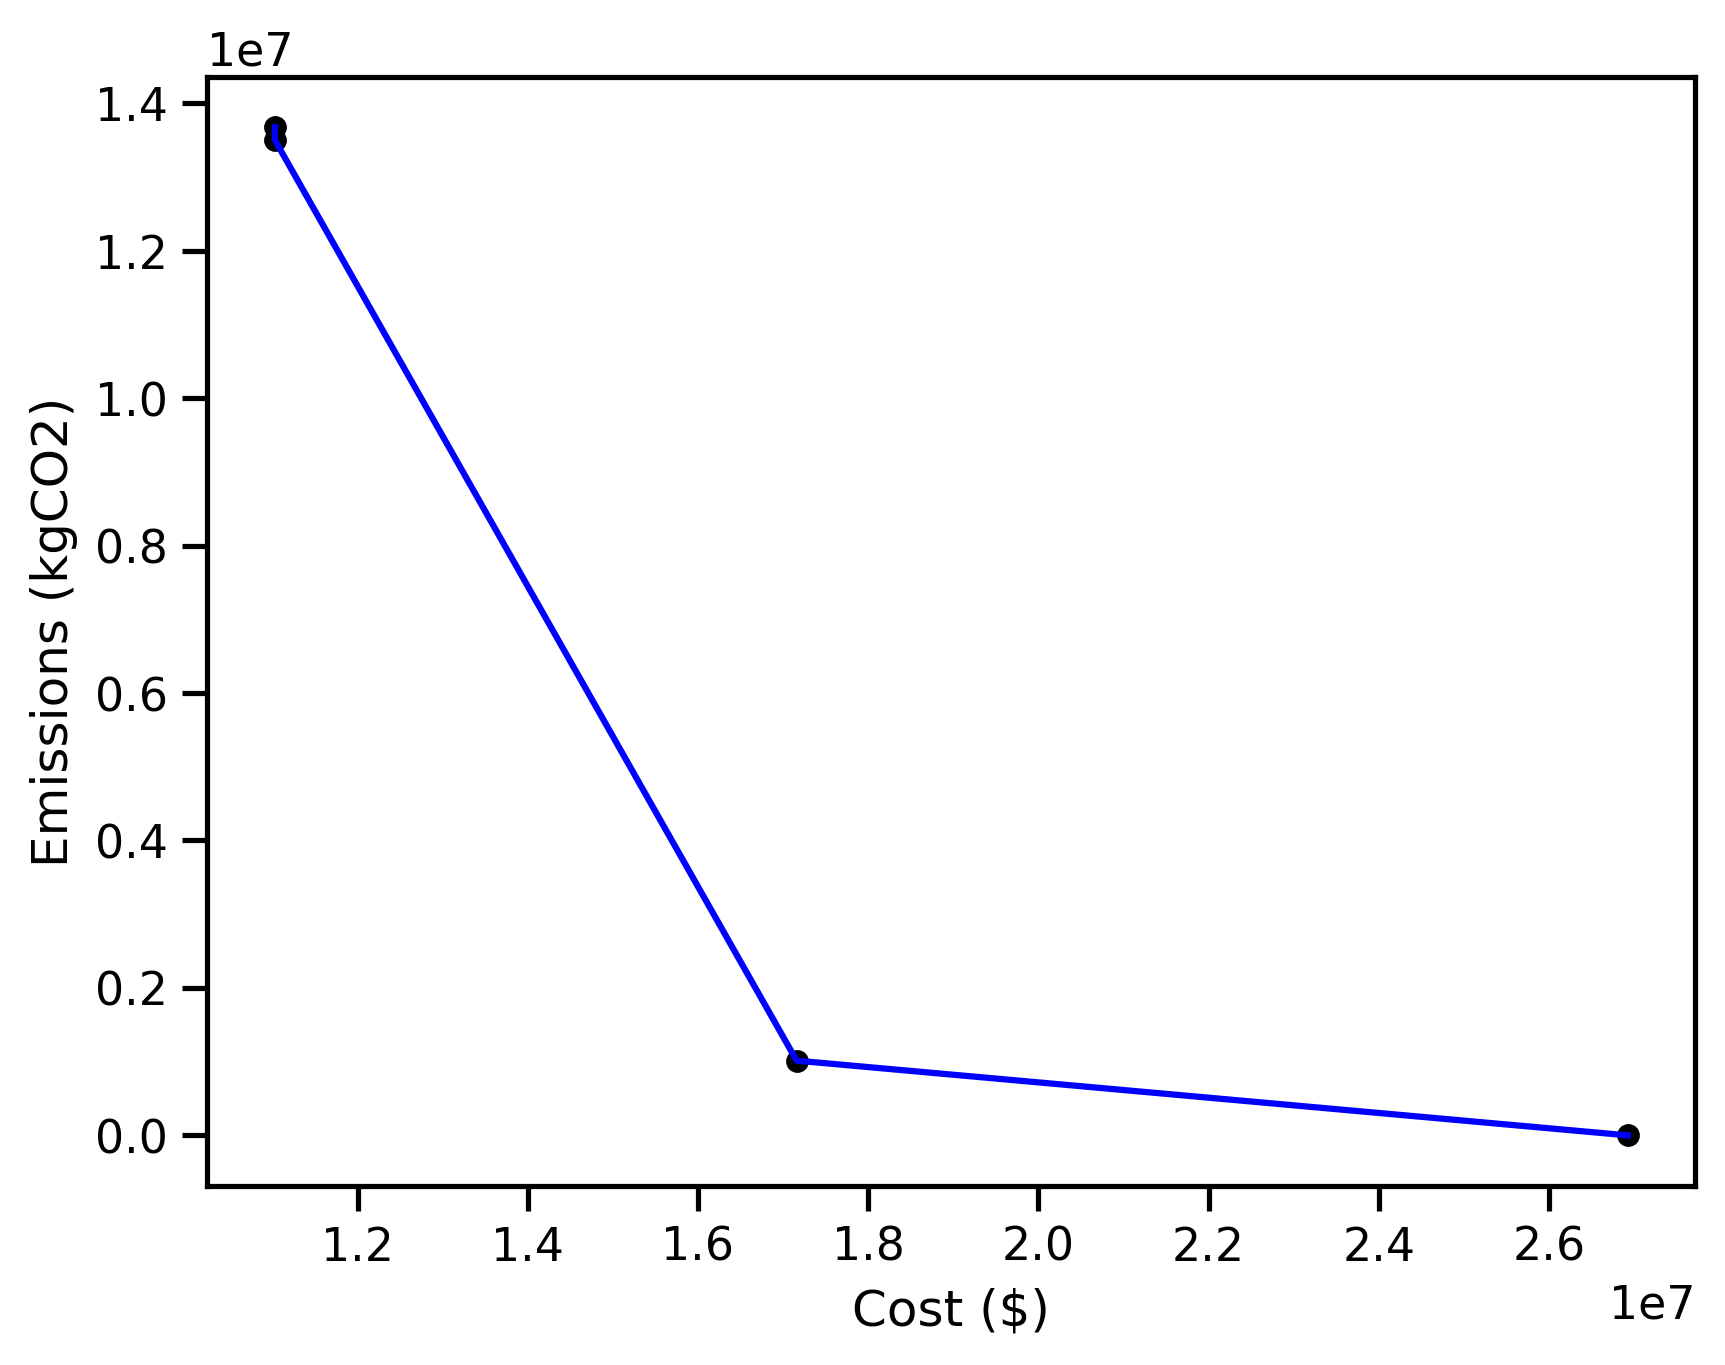

In [26]:
# Plot the results: cost vs emissions
plt.scatter(allCosts, allEmissions, color="black", s=20)
# Link the points of the Pareto frontier with a blue line
plt.plot(pareto_frontier[:,0], pareto_frontier[:,1], color="blue")
plt.xlabel("Cost ($)")
plt.ylabel("Emissions (kgCO2)")